In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')

In [124]:
#Read Training File
df_train=pd.read_csv("train.csv")
df_train["source"]="Train"

#Read Test File
df_test=pd.read_csv("test.csv")
df_test["source"]="Test"

#Concat Dataset and split to X and Y
df=pd.concat([df_test,df_train], axis=0)
X=df.drop("SalePrice",axis=1)
y=df["SalePrice"]

#Save source information as series and drop from DF
source=df["source"]
df.drop("source", axis=1, inplace=True)

# Data Exploration

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1459
Data columns (total 81 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

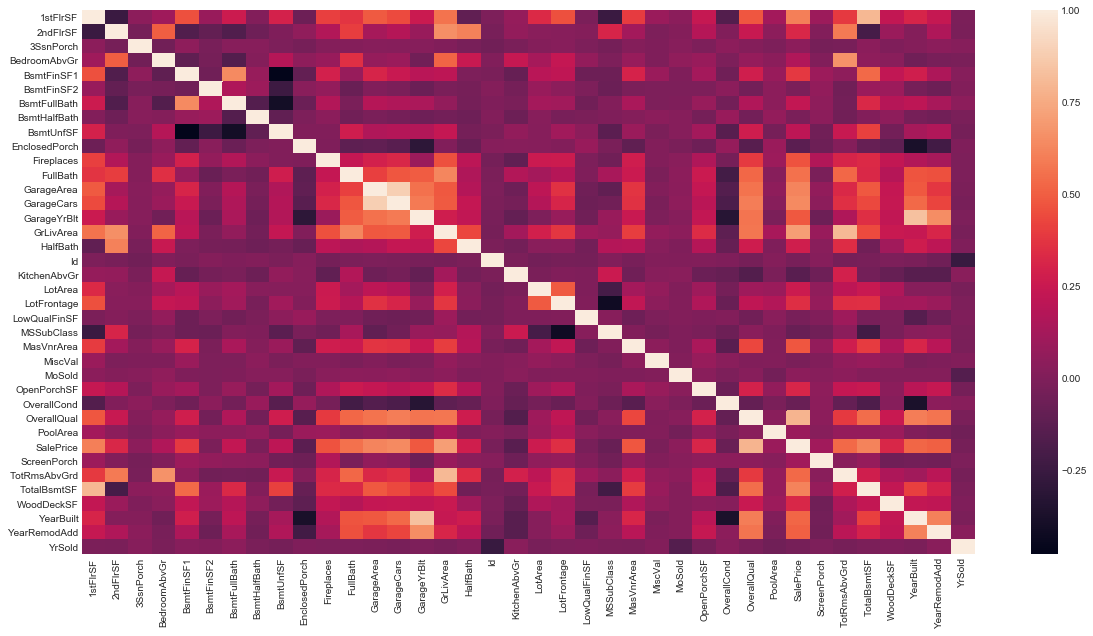

In [126]:
# Plot correlations
plt.figure(figsize=(20,10))
sns.heatmap(df.corr())

# Feature Engineering: Cleaning

In [127]:
# Defining categorical and numerical variables
num_cols = X.columns.values[(X.dtypes=="int64")|(X.dtypes=="float64")]
cat_cols = X.columns.values[X.dtypes=="object"]

## Explore Numerical Variables

1stFlrSF


<Figure size 432x288 with 0 Axes>

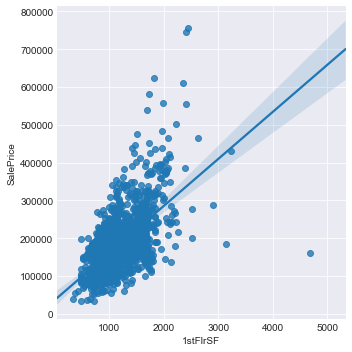

2ndFlrSF


<Figure size 432x288 with 0 Axes>

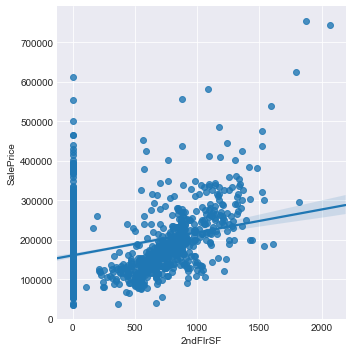

3SsnPorch


<Figure size 432x288 with 0 Axes>

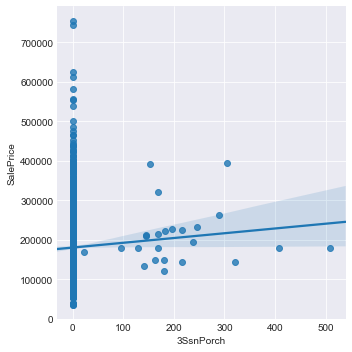

BedroomAbvGr


<Figure size 432x288 with 0 Axes>

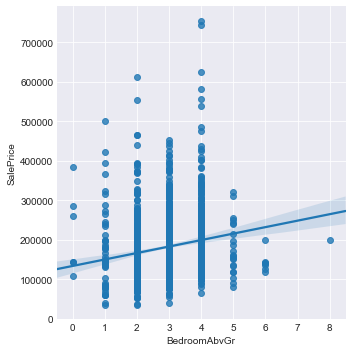

BsmtFinSF1


<Figure size 432x288 with 0 Axes>

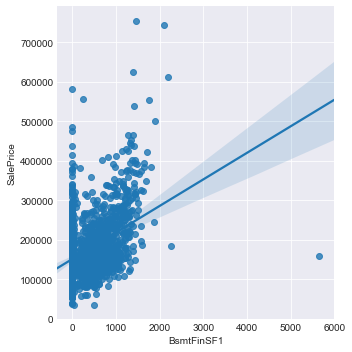

BsmtFinSF2


<Figure size 432x288 with 0 Axes>

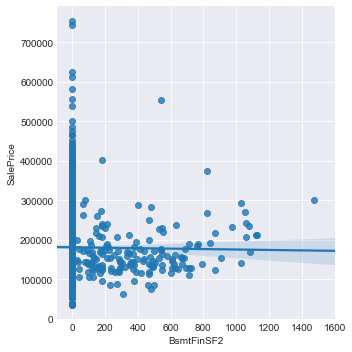

BsmtFullBath


<Figure size 432x288 with 0 Axes>

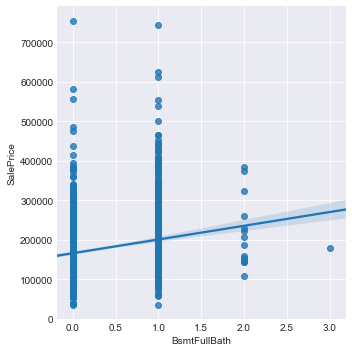

BsmtHalfBath


<Figure size 432x288 with 0 Axes>

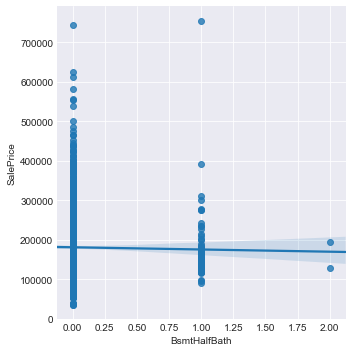

BsmtUnfSF


<Figure size 432x288 with 0 Axes>

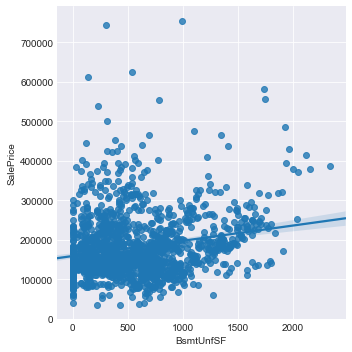

EnclosedPorch


<Figure size 432x288 with 0 Axes>

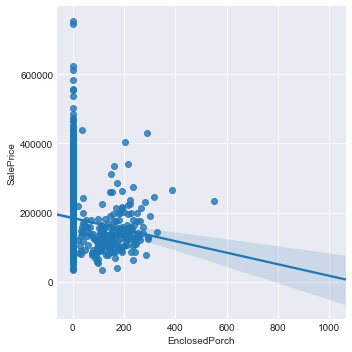

Fireplaces


<Figure size 432x288 with 0 Axes>

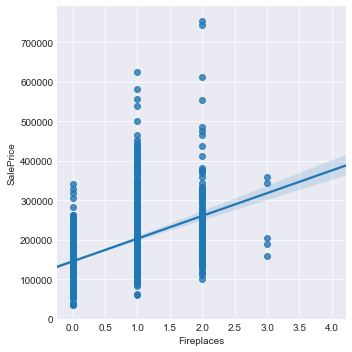

FullBath


<Figure size 432x288 with 0 Axes>

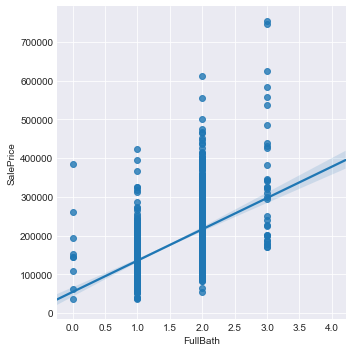

GarageArea


<Figure size 432x288 with 0 Axes>

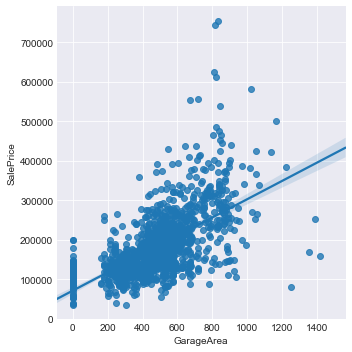

GarageCars


<Figure size 432x288 with 0 Axes>

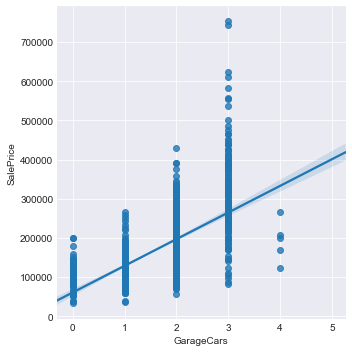

GarageYrBlt


<Figure size 432x288 with 0 Axes>

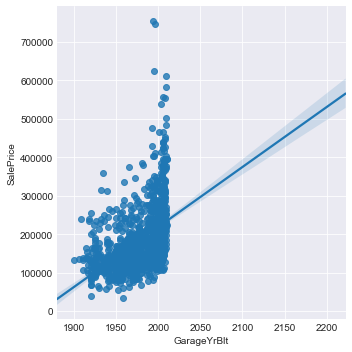

GrLivArea


<Figure size 432x288 with 0 Axes>

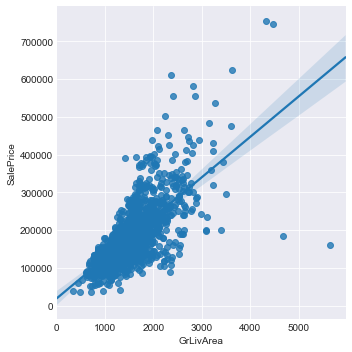

HalfBath


<Figure size 432x288 with 0 Axes>

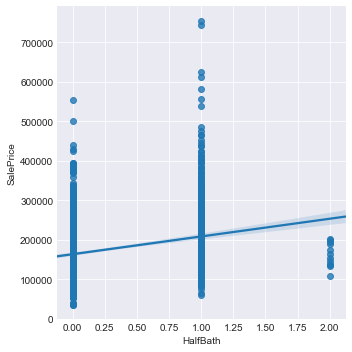

Id


<Figure size 432x288 with 0 Axes>

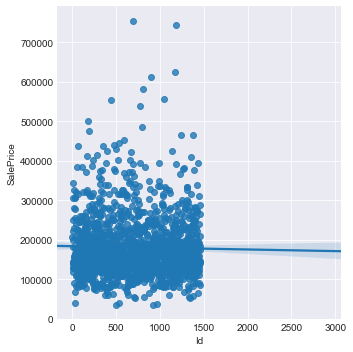

KitchenAbvGr


<Figure size 432x288 with 0 Axes>

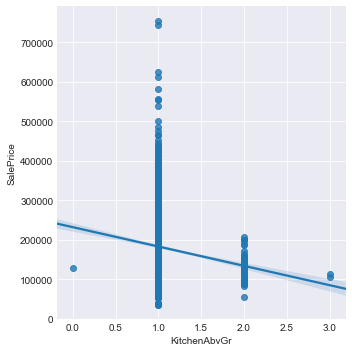

LotArea


<Figure size 432x288 with 0 Axes>

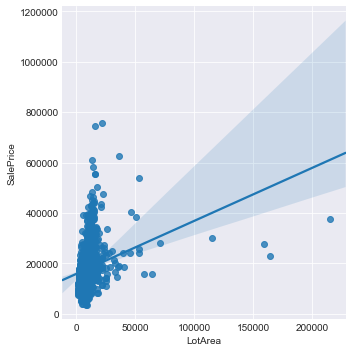

LotFrontage


<Figure size 432x288 with 0 Axes>

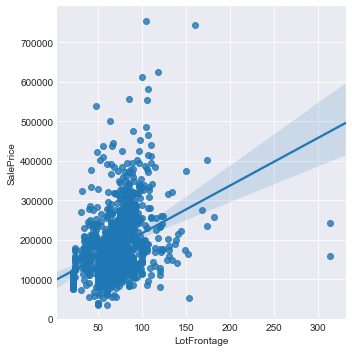

LowQualFinSF


<Figure size 432x288 with 0 Axes>

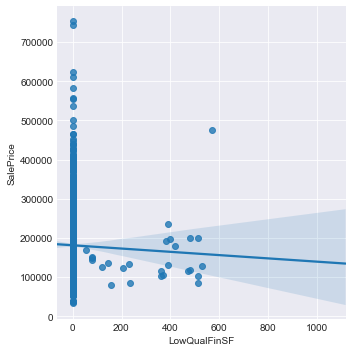

MSSubClass


<Figure size 432x288 with 0 Axes>

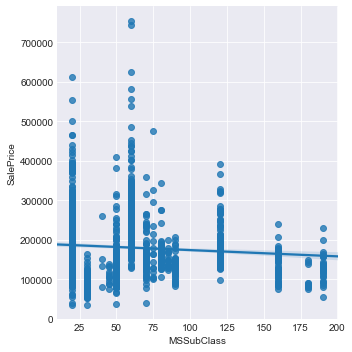

MasVnrArea


<Figure size 432x288 with 0 Axes>

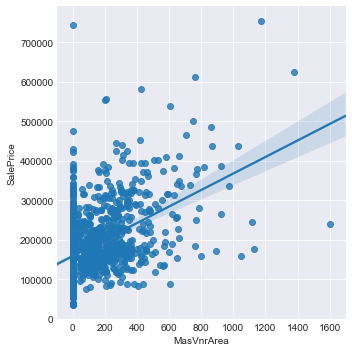

MiscVal


<Figure size 432x288 with 0 Axes>

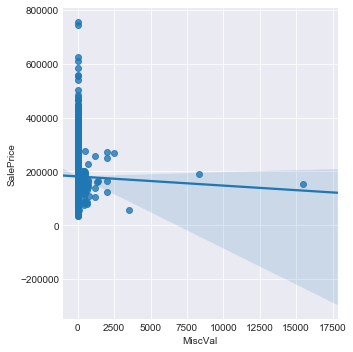

MoSold


<Figure size 432x288 with 0 Axes>

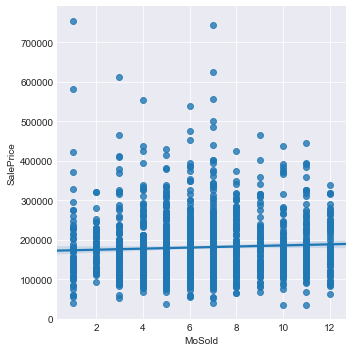

OpenPorchSF


<Figure size 432x288 with 0 Axes>

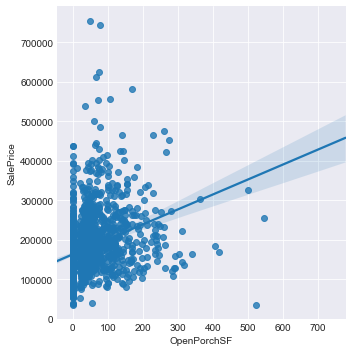

OverallCond


<Figure size 432x288 with 0 Axes>

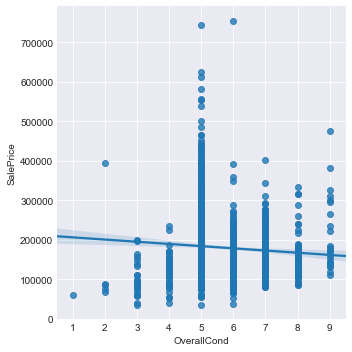

OverallQual


<Figure size 432x288 with 0 Axes>

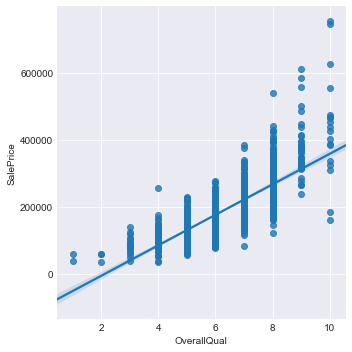

PoolArea


<Figure size 432x288 with 0 Axes>

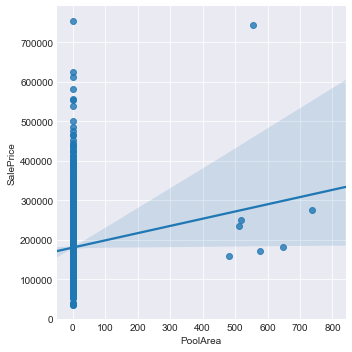

ScreenPorch


<Figure size 432x288 with 0 Axes>

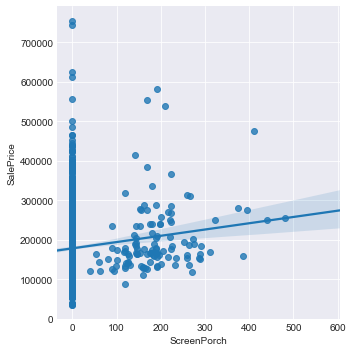

TotRmsAbvGrd


<Figure size 432x288 with 0 Axes>

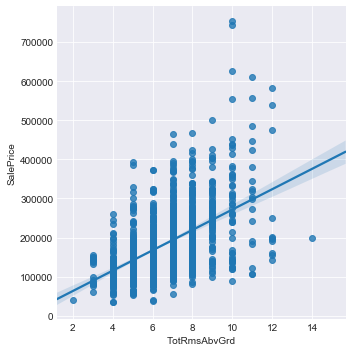

TotalBsmtSF


<Figure size 432x288 with 0 Axes>

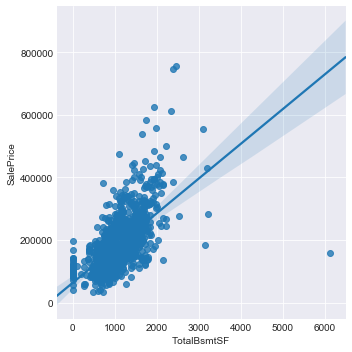

WoodDeckSF


<Figure size 432x288 with 0 Axes>

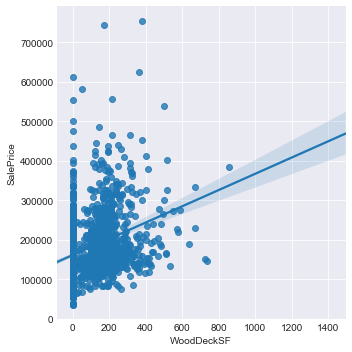

YearBuilt


<Figure size 432x288 with 0 Axes>

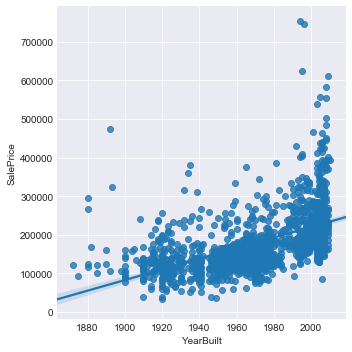

YearRemodAdd


<Figure size 432x288 with 0 Axes>

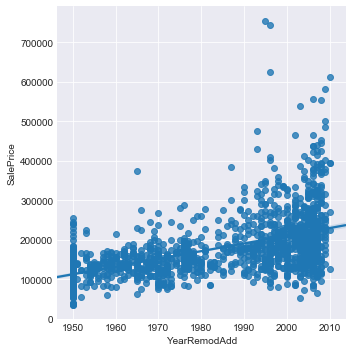

YrSold


<Figure size 432x288 with 0 Axes>

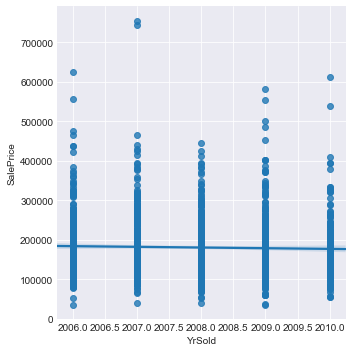

In [129]:
for each in num_cols:
    plt.figure()
    print(each)
    sns.lmplot(x=each,y="SalePrice",data=df)
    plt.show()

BedroomAbvGr
BsmtFullBath
Fireplaces
GarageCars

These columns are having non-linear relationships, so better to convert

### False num_cols to categorical

In [130]:
num_cols

array(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea',
       'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Id',
       'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF',
       'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF',
       'OverallCond', 'OverallQual', 'PoolArea', 'ScreenPorch',
       'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt',
       'YearRemodAdd', 'YrSold'], dtype=object)

In [131]:
# MSSubClass: Identifies the type of dwelling involved in the sale.	
# MoSold: Month Sold (MM)
# YrSold: Year Sold (YYYY)
# OverallCond: Rates the overall condition of the house
# OverallQual: Rates the overall material and finish of the house
# YearBuilt
# YearRemodAdd

false_nums = ["MSSubClass","MoSold","YrSold","OverallCond","OverallQual","YearBuilt","YearRemodAdd","BedroomAbvGr", "GarageCars", "Fireplaces","BsmtFullBath"]

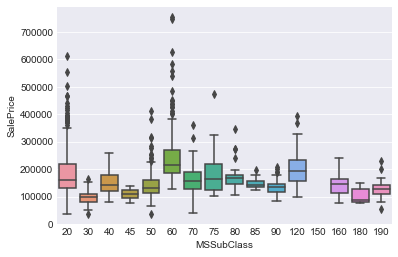

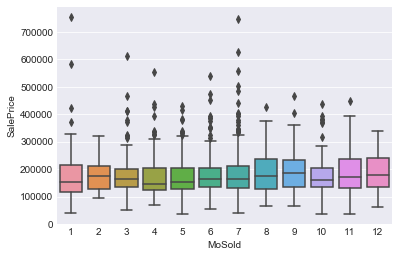

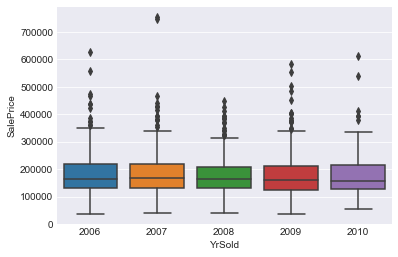

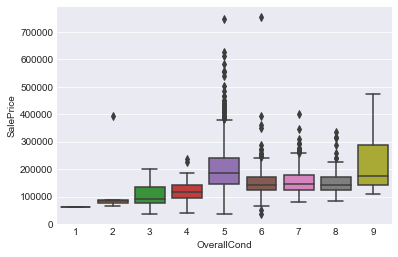

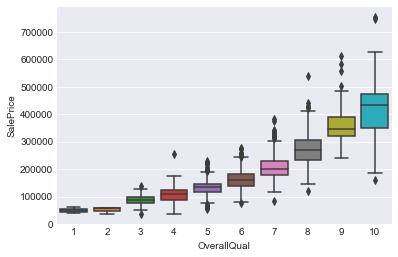

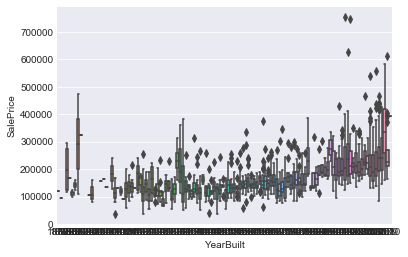

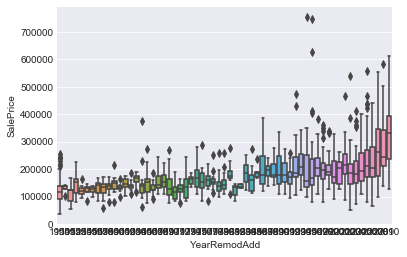

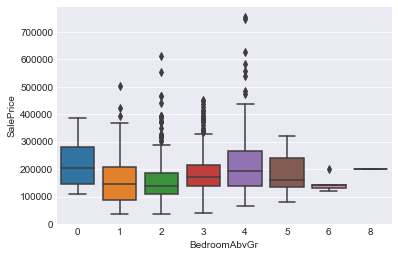

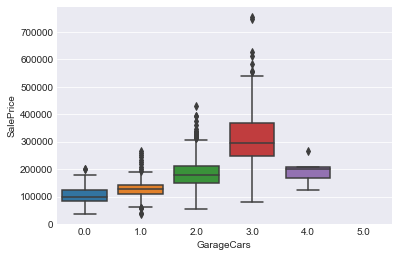

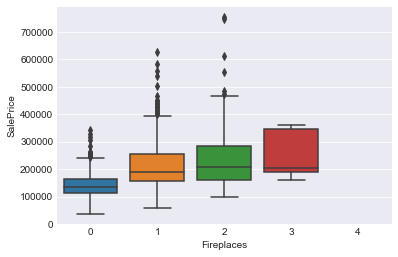

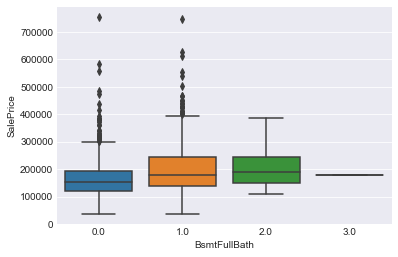

In [132]:
for each in false_nums:
    plt.figure()
    sns.boxplot(X[each],y=y)

YearBuild and YearRemodAdd are kept as continuous, because they are "streng monoton steigend" and would cause to much additional variables.

In [133]:
false_nums = ["MSSubClass","MoSold","YrSold","OverallCond","OverallQual", "BedroomAbvGr", "GarageCars", "Fireplaces","BsmtFullBath"]

for each in false_nums:
    X[each]=X[each].astype('object')

In [134]:
# Defining categorical and numerical variables
num_cols=X.columns.values[(X.dtypes=="int64")|(X.dtypes=="float64")]
cat_cols=X.columns.values[X.dtypes=="object"]

### Outlier/Data Errors

In [135]:
X[num_cols].describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtFinSF1,BsmtFinSF2,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,FullBath,GarageArea,...,MasVnrArea,MiscVal,OpenPorchSF,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
count,2919.000000,2919.000000,2919.000000,2918.000000,2918.000000,2917.000000,2918.000000,2919.000000,2919.000000,2918.000000,...,2896.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2918.000000,2919.000000,2919.000000,2919.000000
mean,1159.581706,336.483727,2.602261,441.423235,49.582248,0.061364,560.772104,23.098321,1.568003,472.874572,...,102.201312,50.825968,47.486811,2.251799,16.062350,6.451524,1051.777587,93.709832,1971.312778,1984.264474
std,392.362079,428.701456,25.188169,455.610826,169.205611,0.245687,439.543659,64.244246,0.552969,215.394815,...,179.334253,567.402211,67.575493,35.663946,56.184365,1.569379,440.766258,126.526589,30.291442,20.894344
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1872.000000,1950.000000
25%,876.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.000000,0.000000,1.000000,320.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,793.000000,0.000000,1953.500000,1965.000000
50%,1082.000000,0.000000,0.000000,368.500000,0.000000,0.000000,467.000000,0.000000,2.000000,480.000000,...,0.000000,0.000000,26.000000,0.000000,0.000000,6.000000,989.500000,0.000000,1973.000000,1993.000000
75%,1387.500000,704.000000,0.000000,733.000000,0.000000,0.000000,805.500000,0.000000,2.000000,576.000000,...,164.000000,0.000000,70.000000,0.000000,0.000000,7.000000,1302.000000,168.000000,2001.000000,2004.000000
max,5095.000000,2065.000000,508.000000,5644.000000,1526.000000,2.000000,2336.000000,1012.000000,4.000000,1488.000000,...,1600.000000,17000.000000,742.000000,800.000000,576.000000,15.000000,6110.000000,1424.000000,2010.000000,2010.000000


In [143]:
for each in num_cols:
    IQR = X[each].quantile(0.75)-X[each].quantile(0.25)
    lower_bound = X[each].quantile(0.25)-IQR*1.5
    upper_bound = X[each].quantile(0.75)+IQR*1.5
    outlier= (X[each]<lower_bound)|(X[each]>upper_bound)
    print(str(each)+": "+str(outlier.sum()))

1stFlrSF: 42
2ndFlrSF: 8
3SsnPorch: 37
BsmtFinSF1: 15
BsmtFinSF2: 347
BsmtHalfBath: 175
BsmtUnfSF: 53
EnclosedPorch: 459
FullBath: 4
GarageArea: 42
GarageYrBlt: 3
GrLivArea: 74
HalfBath: 0
Id: 0
KitchenAbvGr: 134
LotArea: 128
LotFrontage: 198
LowQualFinSF: 40
MasVnrArea: 200
MiscVal: 103
OpenPorchSF: 159
PoolArea: 13
ScreenPorch: 256
TotRmsAbvGrd: 51
TotalBsmtSF: 122
WoodDeckSF: 67
YearBuilt: 9
YearRemodAdd: 0


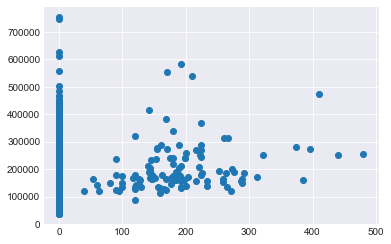

In [145]:
plt.scatter(X["ScreenPorch"],y)

In [ ]:
#ScreenPorch to yes and no?

In [147]:
def porch(x):
    if x>0:
        return "porch"
    else:
        return "no porch"
        
X["ScreenPorch_cat"] = X["ScreenPorch"].apply(lambda x: porch(x))

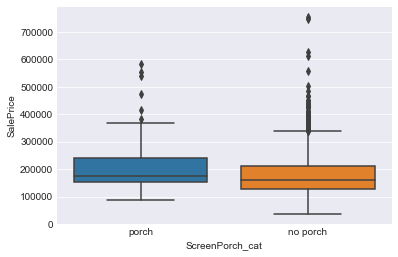

In [151]:
sns.boxplot(X["ScreenPorch_cat"],y)

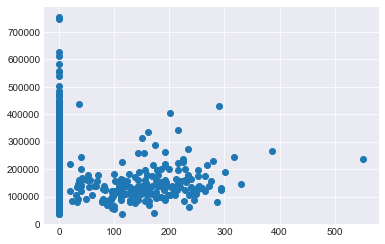

In [152]:
plt.scatter(X["EnclosedPorch"],y)

In [153]:
def porch(x):
    if x>0:
        return "porch"
    else:
        return "no porch"
        
X["EnclosedPorch_cat"] = X["EnclosedPorch"].apply(lambda x: porch(x))

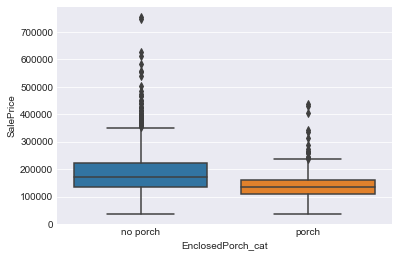

In [154]:
sns.boxplot(X["EnclosedPorch_cat"],y)

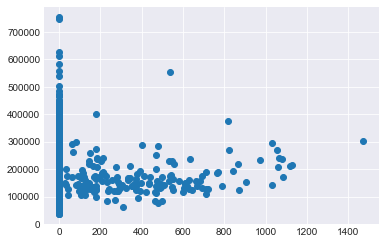

In [158]:
plt.scatter(X["BsmtFinSF2"],y)

In [160]:
def bsmt(x):
    if x>0:
        return "Bsmt"
    else:
        return "no Bsmt"
        
X["BsmtFinSF2_cat"] = X["BsmtFinSF2"].apply(lambda x: bsmt(x))

TypeError: '>' not supported between instances of 'str' and 'int'

In [161]:
sns.boxplot(X["BsmtFinSF2_cat"],y)

KeyError: 'BsmtFinSF2_cat'

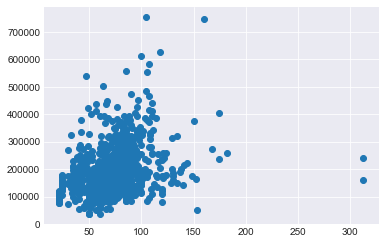

In [155]:
plt.scatter(X["LotFrontage"],y)

### Relationship Checking (numerical variables)

In [72]:
Xnum_y = X[num_cols]
Xnum_y["SalePrice"]=y

In [90]:
#Show top10 absolute correlations with "Sale Price"
top5_nums = abs(Xnum_y.corr()["SalePrice"].sort_values(ascending=False)).head(6)
top5_numscols=top5_nums.index.values
print(top5_nums)

SalePrice      1.000000
GrLivArea      0.708624
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
FullBath       0.560664
Name: SalePrice, dtype: float64


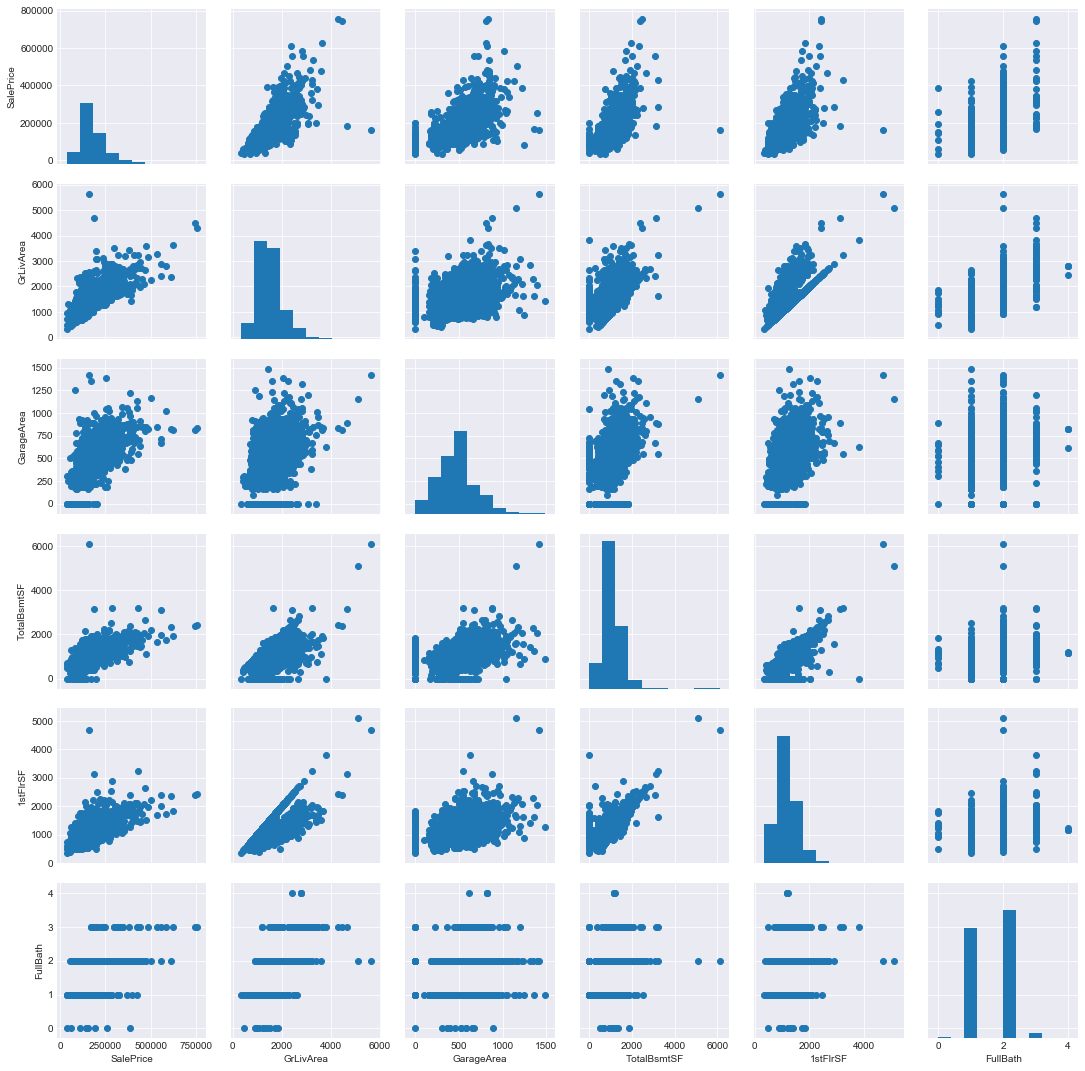

In [91]:
#Pairgrid for Top10
g = sns.PairGrid(Xnum_y[top5_numscols])
g.map_offdiag(plt.scatter)
g.map_diag(plt.hist)

## Missing Values

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(X[num_cols].isnull())

- Deep dive into "GarageYrBlt" and "Lot Frontage"
 - "GarageYrBlt" => insert "YearBuild"
 - "Lot Frontage" => median
- Replace all others with Median Value

In [ ]:
# Replace "GarageYrBlt"
X["GarageYrBlt"].describe()

In [ ]:
X["GarageYrBlt"]=X["GarageYrBlt"].fillna(X["YearBuilt"])

In [ ]:
#Fill other columns
for each in X[num_cols]:
    X[each]=X[each].fillna(np.mean(X[each]))
    #X[each]=X[each].fillna(0)

## Normalization

In [102]:
# Standardize 
for each in X[num_cols]:
    X[each] = (X[each]-X[each].min())/(X[each].max()-X[each].min())

## One-Hot-Encoding

In [103]:
for each in cat_cols:
    X[each]=pd.Categorical(X[each])
    dummies=pd.get_dummies(X[each], prefix=str(each))
    X=pd.concat([X,dummies],axis=1)
    X.drop(each,axis=1,inplace=True)

## Split Training and Test

In [104]:
#Split Set (using source)
def sync_datasets(X,y):
    X_train = X[source=="Train"]
    y_train = y[source=="Train"]
    X_test= X[source=="Test"]
    return X_train, y_train, X_test

X_train, y_train, X_test = sync_datasets(X,y)

In [105]:
X.shape

(2919, 357)

# Feature Selection

In [106]:
from sklearn.ensemble import RandomForestRegressor
RandomForest = RandomForestRegressor()

## Recursive Feature Selection
This step should help us to get on idea on the right number of parameters.

In [108]:
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

In [109]:
rfecv = RFECV(estimator=boost,scoring="explained_variance", step=5, cv=6 )
rfecv.fit(X=X_train,y=y_train)

[20:37:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:37:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:37:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:37:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:37:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:37:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:37:19] WARNI

RFECV(cv=6,
   estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
   n_jobs=1, scoring='explained_variance', step=5, verbose=0)

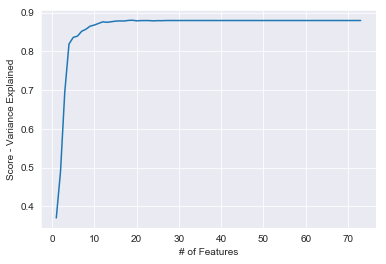

Optimal number of features 87. Performance 0.8801374821688208


In [110]:
# Plot relationship #of features and performance
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.xlabel("# of Features")
plt.ylabel("Score - Variance Explained")
plt.show()
print("Optimal number of features {}. Performance {}".format(rfecv.n_features_, max(rfecv.grid_scores_)))

In [520]:
#rfe = RFE(xgb_tuned, 10)
#rfe.fit(X=X_train,y=y_train)

[14:21:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:21:23] WARNI

RFE(estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
  n_features_to_select=10, step=1, verbose=0)

In [112]:
#Select important columns
#selected_cols=X_train.columns.values[rfecv.support_]
selected_cols=X_train.columns.values[rfecv.support_]
X_train=X_train[selected_cols]
X_test=X_test[selected_cols]

In [111]:
X_train.shape

(1460, 357)

# Feature Engineering: Creative

## Dependent Variable

(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <a list of 10 Patch objects>)

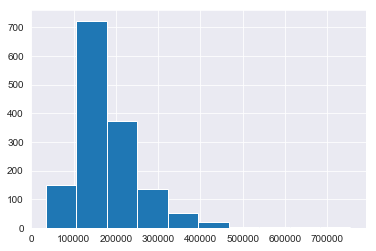

In [66]:
plt.hist(y_train)

(array([  5.,  12.,  54., 184., 470., 400., 220.,  90.,  19.,   6.]),
 array([10.46024211, 10.7676652 , 11.07508829, 11.38251138, 11.68993448,
        11.99735757, 12.30478066, 12.61220375, 12.91962684, 13.22704994,
        13.53447303]),
 <a list of 10 Patch objects>)

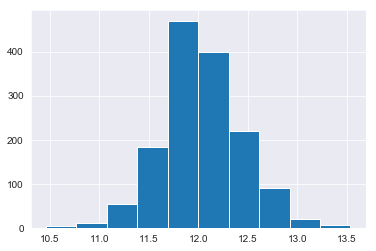

In [67]:
plt.hist(np.log(y_train))

In [68]:
#y_train=np.log(y_train)

# Train Models

## Model Initialization

In [ ]:
#Random Forest Regressor
RandomForest.fit(X_train,y_train)

In [114]:
from sklearn.linear_model import LinearRegression
Regression=LinearRegression()
Regression.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [115]:
from sklearn.svm import SVR
SVR=SVR()
SVR.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [116]:
from sklearn.ensemble import AdaBoostRegressor
Ada=AdaBoostRegressor()
Ada.fit(X=X_train,y=y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None)

In [117]:
from sklearn.ensemble import GradientBoostingRegressor
Boosting=GradientBoostingRegressor()
Boosting.fit(X=X_train,y=y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [118]:
import xgboost as xgb
boost=xgb.XGBRegressor()
boost.fit(X_train,y_train)

C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:45:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [119]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(X_train,y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [120]:
from sklearn.ensemble import BaggingRegressor
bagging = BaggingRegressor()
bagging.fit(X_train,y_train)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [121]:
from sklearn.ensemble import ExtraTreesRegressor
extra = ExtraTreesRegressor()
extra.fit(X_train,y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [122]:
#model = [lasso,boost, Regression, RandomForest, SVR, Ada,Boosting]
model = [boost,extra, bagging, lasso, Regression, RandomForest, SVR, Ada,Boosting]

## Cross-Validation for Model Selection

In [123]:
from sklearn.model_selection import cross_val_score

In [124]:
for each in model:
    scores = cross_val_score(estimator=each,X=X_train, y=y_train, cv=6,scoring='explained_variance') 
    print(str(each)+" "+str(scores.mean()))

C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:45:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:45:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:45:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:45:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:45:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:45:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1) 0.8834296047073312
ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=F

# Hyperparameter - Tuning

In [82]:
from sklearn.model_selection import GridSearchCV

In [83]:
#params = {"min_samples_leaf":[1,2,3,5,10,15], "min_samples_split": [2,3,5,10,15]}
params = {"min_child_weight":[1,2,3,5,10], "learning_rate":[0.05,0.1,0.2,0.5], }
#params = {"alpha":[0.1, 0.3, 0.5, 0.9], "learning_rate": [0.05,0.1,0.2],"min_samples_leaf":[1,2,3,5,10]}


In [84]:
tuning = GridSearchCV(boost,cv=5, param_grid=params)
tuning.fit(X_train, y_train)
tuning.best_params_

C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'learning_rate': 0.2, 'min_child_weight': 3}

In [152]:
tuning.best_params_

{'learning_rate': 0.2, 'min_child_weight': 3}

In [194]:
xgb_tuned = xgb.XGBRegressor(colsample_bytree=1,
                 gamma=0.5,                 
                 learning_rate=0.005,
                 max_depth=9,
                 min_child_weight=1.5,
                 n_estimators=5000,                                                                    
                 reg_alpha=0.4,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
xgb_tuned.fit(X_train, y_train)
scores = cross_val_score(estimator=xgb_tuned,X=X_train, y=y_train, cv=10,scoring='explained_variance') 
print(scores.mean())

C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\sklearn.py:235: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


[21:25:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\sklearn.py:235: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


[21:26:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\sklearn.py:235: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


[21:27:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\sklearn.py:235: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


[21:29:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\sklearn.py:235: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


[21:30:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\sklearn.py:235: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


[21:31:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\sklearn.py:235: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


[21:32:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\sklearn.py:235: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


[21:34:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\sklearn.py:235: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


[21:35:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\sklearn.py:235: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


[21:36:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dpleus\AppData\Local\Continuum\anaconda\lib\site-packages\xgboost\sklearn.py:235: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


[21:37:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8915954246755737


In [192]:
boosted_tuned = GradientBoostingRegressor()
boosted_tuned.fit(X_train, y_train)
scores = cross_val_score(estimator=boosted_tuned,X=X_train, y=y_train, cv=10,scoring='explained_variance') 
print(scores.mean())

0.886420792931134


# Prediction

In [475]:
#Build Esemble

In [136]:
#Custom ensemble
model = [boost,extra, lasso, RandomForest, Ada]
weights = [0.3, 0.15, 0.25, 0.15, 0.15]

array = {}
i=1

for each in model:
    array[i] = each.predict(X_test)
    i=i+1

ensemble_reg = np.zeros(1459)

for each in range(1, len(weights)+1):
    ensemble_reg=ensemble_reg + array[each]*weights[each-1]
    
#ensemble_reg

In [195]:
prediction = xgb_tuned.predict(X_test)

In [196]:
# Reverting log
#prediction = np.exp(ensemble_reg)

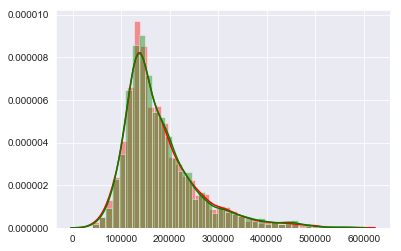

In [197]:
sns.distplot(xgb_tuned.predict(X_test), color="red")
sns.distplot(boost.predict(X_test), color="green")
#sns.distplot(prediction, color="red")

In [198]:
# Writing Prediction to *.csv
submission = pd.read_csv("sample_submission.csv")
submission["SalePrice"]=prediction
submission.to_csv("submission.csv", index=False)

# Learnings

- Vor one-hot-enconding training und test dataset zusammen 
- What is a stratified fold?
- Variance explained for Regression?
- Wie X[each] iteration

# Results

1. Submit: Just one hot-encoding and Random Forest (Default): 0.15554
2. Submit: One hot-encoding and Random Forest (Default), RFECV: 0.15051 (2.857)
3. Submit: Like 2, +Log Target Variable, +Fill missing values with mean instead of 0: 
4. Submit: Like 3, - Fill missing values with mean instead of 0: 0.15727
5. Submit: Normalized, median as input, pre-selected features: 0.16282
6. Submit: Model - Regression: 0.16721
7. Submit: Model - Boosting:0.19108 => overfitting
8. Submit: Random Forest, + Missing Values (Garage) + Standardization (just for nums) + Garage NaN more sophisticated:  0.15394
9. Submit: Wie 8, bloß mit Hyperparameter Tuning: 0.16575
10. Submit: gxboost: 0.13471
11. Submit: Random Forest, +Num to cols, +Log Target: 0.15785
12. Submit: like 11, with SVR: 0.14918
13. Submit: like 12, with gxb: 0.14512
14. Submit: like 13, with gxb (50 features): 0.15381
15. Submit: like 14, custom ensemble: 0.14741
16. Submit: like 15, drop log: 0.14743
17. Submit: like 16, with prediction + 5000: 0.15298
18. Submit: gxboost_tuned incl. specific RFECV: 0.14984
19. Submit: GradientBoostingRegressor: 0.15016
20. Submit: XGB with only top 10 features: 0.18058
21. Submit: XGB with new categorized features: 0.14808
22. Submit: Stacked Model: 0.14608
23. Submit: XGB (hyperparameter tuned): 0.15218
24. Summit: like 23, but manually adjusted: 0.15896
25. Submit: Fixing a typo: 0.15736
26. Submit: 50.000 Instances: 0.14279

In [ ]:
prediction

# Ideas
- Engineering
 - Remove colinearity
- More Algos

- Stacked prediction model (also Linear Models)
- Robust against outlier

=> xgboost less overfitting

In [163]:
y_train.shape

(1460,)

In [164]:
df["diff"]=boost.predict(X_train)-y_train

In [171]:
df.corr()["diff"].sort_values()

SalePrice       -0.295125
OverallQual     -0.076359
BsmtFullBath    -0.072795
OverallCond     -0.054045
BsmtFinSF1      -0.053946
MasVnrArea      -0.051649
LotArea         -0.045988
TotalBsmtSF     -0.044108
PoolArea        -0.036551
GarageArea      -0.030681
YearBuilt       -0.029490
FullBath        -0.028700
YearRemodAdd    -0.024995
OpenPorchSF     -0.023083
ScreenPorch     -0.023066
3SsnPorch       -0.020470
HalfBath        -0.019920
WoodDeckSF      -0.019610
GarageCars      -0.019422
GarageYrBlt     -0.018897
1stFlrSF        -0.015443
BsmtFinSF2      -0.012759
TotRmsAbvGrd    -0.012123
Fireplaces      -0.010991
MiscVal         -0.010504
GrLivArea       -0.009279
MSSubClass      -0.006757
LotFrontage     -0.005455
MoSold          -0.002994
2ndFlrSF         0.000154
EnclosedPorch    0.007270
Id               0.009083
BsmtHalfBath     0.011542
BedroomAbvGr     0.013579
BsmtUnfSF        0.016599
YrSold           0.017953
KitchenAbvGr     0.018384
LowQualFinSF     0.027969
diff        

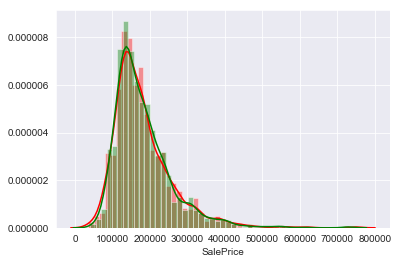

In [173]:
sns.distplot(y_train, color="red")
sns.distplot(boost.predict(X_train), color="green")

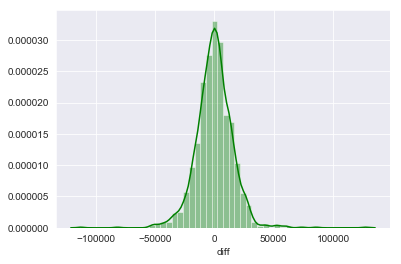

In [175]:
sns.distplot(df["diff"], color="green")

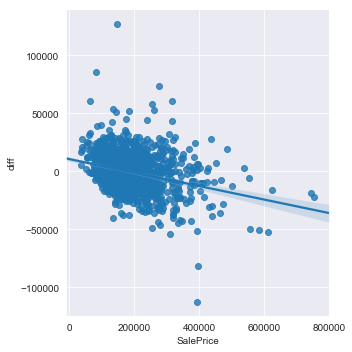

In [179]:
sns.lmplot("SalePrice", "diff" , df)